This system predicts grammatical quality by analyzing audio and text. First, Whisper converts audio into text, which is then processed for cleaning (language detection, normalization). Poor-quality text results in reliance on audio features alone. RoBERTa extracts text features (last layers fine-tuned), and Whisper extracts robust audio features, capturing voice nuances. These features are combined and fed into a neural network (HybridGrammarScorer). The model is trained on 80% of the data, validated on 20%, optimizing for Pearson correlation. Audio enriches context and handles noisy data. The best model predicts grammatical quality for test data, with results adjusted for realistic output.

**Task: Grammatical Quality Prediction**

Our goal is to accurately assess the grammatical quality of spoken language. To achieve this, we've designed a multimodal pipeline that leverages both textual and audio features.

**Pipeline Stages:**

**Audio to Text Conversion (Whisper):**

The initial stage involves transcribing the audio input using OpenAI's Whisper model. This provides us with a textual representation of the spoken language.
It is noted that the quality of these transcripts can vary significantly, with some containing multiple languages, minimal coherent text, or considerable noise.

**Text Preprocessing:**

The transcribed text undergoes preprocessing to enhance its quality. This includes:
* Language detection to identify if it is English.
* Regular expression cleaning to remove unwanted characters and noise.
* spaCy-based normalization to standardize text (e.g., lemmatization, tokenization).
* The transcribed text undergoes cleaning and normalization. Crucially, if the preprocessing reveals the text is not up to the mark—for example, it's not in English, contains very little information, or has excessive noise—the system returns an empty text output, recognizing that text features will be unreliable.

**Feature Extraction:**

*Text Features (RoBERTa):*

For high-quality text, we extract features using a pretrained RoBERTa model.
To balance performance and computational efficiency, we fine-tune only the last two layers of the RoBERTa encoder.

*Audio Features (Whisper):*

* Regardless of text quality, we extract audio features using the Whisper model.
* Audio features enhance grammar prediction by capturing intonation, pronunciation, and voice quality, providing context and robustness beyond text. They are especially valuable when text quality is poor.
*Feature Combination:*
If the text is of good quality, the text and audio embeddings are concatenated.
if the text is of bad quality, only the audio embeddings are used.


**Model Training and Validation (HybridGrammarScorer):**

* The combined (or audio-only) features are fed into our hybrid model, HybridGrammarScorer, which consists of several fully connected layers.
* The model is trained to predict a regression score representing grammatical quality.
* The dataset is split into 80% training data and 20% validation data.
* The model is trained using Mean Squared Error (MSE) loss and the Adam optimizer.
* The model's performance is evaluated using metrics like Pearson correlation, MSE, MAE, and R².
* The model with the best validation Pearson correlation is selected and saved.

**Test Set Prediction:**

* For the test set, we apply the same preprocessing and feature extraction steps.
* The trained HybridGrammarScorer model generates predictions.
* The final predictions are saved into a submission file.

**CONVERSION of SPEECH TO TEXT**

In [ ]:
    import os
    import pandas as pd
    import torch
    import torchaudio
    from transformers import WhisperProcessor, WhisperForConditionalGeneration

    # Set device: use GPU if available, otherwise CPU.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # =======================================
    # Load the processor and model (for conditional generation).
    whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-small")
    whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)
    whisper_model.eval()

def process_dataset(csv_path, audio_folder, output_csv_path):
    """
    Process audio files listed in the CSV file, generate transcriptions using the Whisper model,
    and save a new CSV with an added 'text' column containing the transcriptions.
    
    Parameters:
        csv_path (str): Path to the CSV file containing filenames.
        audio_folder (str): Directory where the audio files are stored.
        output_csv_path (str): Path where the new CSV file with transcripts will be saved.
    """
    # Read the CSV file.
    df = pd.read_csv(csv_path)
    transcripts = []

    # Process each audio file in the CSV.
    for filename in df["filename"]:
        audio_path = os.path.join(audio_folder, filename)
        print(f"Processing {audio_path}...")
        
        # Load the audio file using torchaudio.
        waveform, sr = torchaudio.load(audio_path)
        
        # If the audio has multiple channels, convert it to mono by averaging.
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        
        # Resample if necessary (Whisper expects a 16kHz sample rate).
        if sr != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
            waveform = resampler(waveform)
            sr = 16000
        
        # Process the waveform into input features.
        input_features = whisper_processor(
            audio=waveform.squeeze().numpy(),
            sampling_rate=sr,
            return_tensors="pt"
        ).input_features.to(device)
        
        # Generate predictions using the model.
        predicted_ids = whisper_model.generate(input_features)
        
        # Decode the predictions to text.
        transcription = whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
        transcripts.append(transcription)
    
    # Add the transcripts as a new column in the DataFrame.
    df["text"] = transcripts
    
    # Save the updated DataFrame to a new CSV file.
    df.to_csv(output_csv_path, index=False)
    print(f"Transcription complete. CSV saved to {output_csv_path}.")

# ----------------------------
# Process the train dataset.
train_csv_path = "/home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/train.csv"
train_audio_folder = "/home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_train"
train_output_csv_path = os.path.join(os.path.dirname(train_csv_path), "train_with_transcripts.csv")
process_dataset(train_csv_path, train_audio_folder, train_output_csv_path)

# ----------------------------
# Process the test dataset.
test_csv_path = "/home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/test.csv"
test_audio_folder = "/home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_test"
test_output_csv_path = os.path.join(os.path.dirname(test_csv_path), "test_with_transcripts.csv")
process_dataset(test_csv_path, test_audio_folder, test_output_csv_path)


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


Processing /home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_train/audio_1261.wav...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Processing /home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_train/audio_942.wav...
Processing /home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_train/audio_1110.wav...
Processing /home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_train/audio_1024.wav...
Processing /home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_train/audio_538.wav...
Processing /home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_train/audio_350.wav...
Processing /home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_train/audio_64.wav...
Processing /home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_train/audio_252.wav...
Processing /home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_train/audio_1304.wav...
Processing /home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_train/audio_1230.wav...
Processing /home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_train/audio_133.wav...
Processing /home/ankur/ASR_Meta/VLM/TTS/grammar/dataset/audios_train/audio_790.wav...
Processing /home/ankur/ASR_Meta/VLM/TTS/grammar/dat

In [6]:
!pip install langdetect

     |████████████████████████████████| 981 kB 2.1 MB/s eta 0:00:01
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=7d98877889e49789946d80f5df63fafd66e2db0e80d3e628065238881cb02467
  Stored in directory: /home/ankur/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


**PROCESSING OF TEXT**

In [ ]:
import spacy
import pandas as pd
import re
import unicodedata
from langdetect import detect, LangDetectException
import os

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Error loading spaCy model. Please ensure it's downloaded.")
    raise

TARGET_LANGUAGE = "en"
MIN_WORD_COUNT = 3

def is_target_language(text, target_lang=TARGET_LANGUAGE):
    try:
        return detect(text) == target_lang
    except LangDetectException:
        return False

def has_noise(text):
    if re.search(r"[^\x00-\x7F]", text):  # Non-ASCII
        return True
    if re.search(r"([^a-zA-Z0-9\s])\1{1,}", text):  # Repeated punctuation
        return True
    if len(text.strip().split()) < MIN_WORD_COUNT:
        return True
    return False

def normalize_text(text):
    return unicodedata.normalize("NFKD", text).lower()

def remove_noise(text):
    text = re.sub(r"([^a-zA-Z0-9\s])\1+", r"\1", text)
    return re.sub(r"\s+", " ", text).strip()

def clean_text_with_spacy(text):
    text = normalize_text(text)
    text = remove_noise(text)
    doc = nlp(text)
    return " ".join([
        token.lemma_ for token in doc
        if not token.is_stop and token.is_alpha and len(token) > 1
    ])

def process_transcripts(csv_path):
    df = pd.read_csv(csv_path)
    cleaned_texts = []

    for text in df["text"]:
        if not isinstance(text, str) or not text.strip():
            cleaned_texts.append("")
            continue

        if not is_target_language(text):
            cleaned_texts.append("")
            continue

        if has_noise(text):
            cleaned_text = clean_text_with_spacy(text)
            cleaned_texts.append(cleaned_text)
        else:
            cleaned_texts.append(text.strip())

    df["cleaned_text"] = cleaned_texts

    # Return appropriate columns
    base_columns = ["filename", "text", "cleaned_text"]
    if "label" in df.columns:
        base_columns.insert(1, "label")  # Insert label after filename

    return df[base_columns]

def save_cleaned_csv(df, original_csv_path, suffix="_cleaned_filtered_N"):
    directory = os.path.dirname(original_csv_path)
    basename = os.path.basename(original_csv_path)
    name, ext = os.path.splitext(basename)
    output_path = os.path.join(directory, f"{name}{suffix}{ext}")
    df.to_csv(output_path, index=False)
    print(f"Cleaned CSV saved to {output_path}")

def clean_and_save_dataset(csv_path):
    df = process_transcripts(csv_path)
    save_cleaned_csv(df, csv_path)

if __name__ == "__main__":
    train_csv_path = "train_with_transcripts.csv"
    test_csv_path = "test_with_transcripts.csv"

    clean_and_save_dataset(train_csv_path)
    clean_and_save_dataset(test_csv_path)


**TRAINING MODEL**

In [ ]:
import logging
from datetime import datetime

# ============ Configure Logging ============
log_filename = f"training_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    handlers=[
        logging.FileHandler(log_filename),
        logging.StreamHandler()
    ]
)


import os
import pandas as pd
import torch
import torch.nn as nn
import torchaudio
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from transformers import AutoTokenizer, WhisperProcessor, WhisperModel
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import logging
from datetime import datetime

# ============ Configure Logging ============
log_filename = f"training_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    handlers=[
        logging.FileHandler(log_filename),
        logging.StreamHandler()
    ]
)

# ============ Configs ============
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AUDIO_DIR = "audios_train"
CSV_PATH = "train_with_transcripts_cleaned_filtered_N.csv"
BATCH_SIZE = 8
EPOCHS = 50
MAX_LENGTH = 256

# ============ Load Models ============
text_model_name = "roberta-base"
whisper_model_name = "openai/whisper-small"

# Load RoBERTa
text_tokenizer = AutoTokenizer.from_pretrained(text_model_name)
text_model = AutoModel.from_pretrained(text_model_name).to(DEVICE)

# Freeze all layers except last two
for param in text_model.parameters():
    param.requires_grad = False
for layer in text_model.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# Load Whisper
whisper_processor = WhisperProcessor.from_pretrained(whisper_model_name)
whisper_model = WhisperModel.from_pretrained(whisper_model_name).to(DEVICE)
whisper_model.eval()
for param in whisper_model.parameters():
    param.requires_grad = False

# ============ Audio Embedding ============
failed_audio_count = 0

def extract_whisper_embedding(audio_path):
    global failed_audio_count
    try:
        waveform, sr = torchaudio.load(audio_path)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        if sr != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
            waveform = resampler(waveform)
        inputs = whisper_processor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt")
        with torch.no_grad():
            encoder_outputs = whisper_model.encoder(inputs.input_features.to(DEVICE))
            emb = encoder_outputs.last_hidden_state.mean(dim=1).squeeze()
        return emb.cpu()
    except Exception as e:
        failed_audio_count += 1
        logging.error(f"Failed to process {audio_path}: {e}")
        return torch.zeros(768)

# ============ Dataset ============
class HybridGrammarDataset(Dataset):
    def __init__(self, df, tokenizer, audio_dir, max_length=256, mean=None, std=None):
        self.df = df
        self.tokenizer = tokenizer
        self.audio_dir = audio_dir
        self.max_length = max_length
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["cleaned_text"] if pd.notna(row["cleaned_text"]) else "[EMPTY]"
        audio_path = os.path.join(self.audio_dir, row["filename"])

        text_inputs = self.tokenizer(text, return_tensors="pt", truncation=True, 
                                    max_length=self.max_length, padding="max_length")
        input_ids = text_inputs["input_ids"].squeeze(0)
        attention_mask = text_inputs["attention_mask"].squeeze(0)

        audio_emb = extract_whisper_embedding(audio_path)
        label = torch.tensor(row["label"], dtype=torch.float)
        
        if self.mean is not None and self.std is not None:
            label = (label - self.mean) / self.std

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "audio_emb": audio_emb,
            "label": label
        }

# ============ Model ============
class HybridGrammarScorer(nn.Module):
    def __init__(self, text_model, hidden_size_text=768, hidden_size_audio=768, combined_hidden=256):
        super().__init__()
        self.text_model = text_model
        self.audio_norm = nn.LayerNorm(hidden_size_audio)
        self.text_norm = nn.LayerNorm(hidden_size_text)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size_text + hidden_size_audio, combined_hidden),
            nn.ReLU(),
            nn.LayerNorm(combined_hidden),
            nn.Linear(combined_hidden, combined_hidden//2),
            nn.ReLU(),
            nn.LayerNorm(combined_hidden//2),
            nn.Linear(combined_hidden//2, 1)
        )

    def forward(self, input_ids, attention_mask, audio_emb):
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = text_output.last_hidden_state[:, 0, :]
        text_emb = self.text_norm(text_emb)
        audio_emb = self.audio_norm(audio_emb)
        combined = torch.cat([text_emb, audio_emb], dim=1)
        return self.fc(combined)

# ============ Prepare Data ============
full_df = pd.read_csv(CSV_PATH)
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

train_mean = train_df["label"].mean()
train_std = train_df["label"].std()

train_dataset = HybridGrammarDataset(train_df, text_tokenizer, AUDIO_DIR, 
                                   mean=train_mean, std=train_std)
val_dataset = HybridGrammarDataset(val_df, text_tokenizer, AUDIO_DIR,
                                  mean=train_mean, std=train_std)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# ============ Train ============
model = HybridGrammarScorer(text_model).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
best_pearson = -1

logging.info(f"Failed audio files during dataset creation: {failed_audio_count}")
logging.info(f"Training started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
logging.info(f"Training parameters: BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}")
logging.info(f"Label stats: Mean={train_mean:.2f}, Std={train_std:.2f}")

for epoch in range(EPOCHS):
    model.train()
    model.text_model.eval()
    total_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training", leave=False)

    for batch in train_bar:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        audio_emb = batch["audio_emb"].to(DEVICE)
        labels = batch["label"].to(DEVICE).unsqueeze(1)

        preds = model(input_ids, attention_mask, audio_emb)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            audio_emb = batch["audio_emb"].to(DEVICE)
            labels = batch["label"].to(DEVICE).unsqueeze(1)

            preds = model(input_ids, attention_mask, audio_emb)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Denormalize
    all_preds = np.array(all_preds) * train_std + train_mean
    all_labels = np.array(all_labels) * train_std + train_mean

    pearson_corr, _ = pearsonr(all_preds, all_labels)
    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)

    logging.info(f"\n Epoch {epoch+1}")
    logging.info(f"   Pearson: {pearson_corr:.4f}  MSE: {mse:.4f}  MAE: {mae:.4f}  R²: {r2:.4f}  Train Loss: {avg_loss:.4f}")

    if pearson_corr > best_pearson:
        best_pearson = pearson_corr
        torch.save(model.state_dict(), "best_whisper_hybrid_model.pt")
        logging.info("    Saved best model")

logging.info(f"\nTraining completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
logging.info(f"Best validation Pearson correlation: {best_pearson:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-04-07 02:33:30,057 - Failed audio files during dataset creation: 0
2025-04-07 02:33:30,058 - Training started at 2025-04-07 02:33:30
2025-04-07 02:33:30,059 - Training parameters: BATCH_SIZE=8, EPOCHS=50
2025-04-07 02:33:30,060 - Label stats: Mean=3.64, Std=1.10
2025-04-07 02:34:35,958 -                                                       
 Epoch 1
2025-04-07 02:34:35,960 -    Pearson: 0.7208  MSE: 0.7258  MAE: 0.6973  R²: 0.4676  Train Loss: 0.8154
2025-04-07 02:34:37,717 -     Saved best model
2025-04-07 02:35:42,921 -                                                       
 Epoch 2
2025-04-07 02:35:42,924 -    Pearson: 0.7398  MSE: 0.7265  MAE: 0.6992  R²: 0.4671  Train Loss: 0.4117
2025-04-

**TEST PREDICTIONS**

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# ============ Configs ============
TEST_CSV_PATH = "test_with_transcripts_cleaned_filtered.csv"  # Path to your test CSV
TEST_AUDIO_DIR = "audios_test"  # Path to test audio files
MODEL_PATH = "best_whisper_hybrid_model.pt"
SUBMISSION_PATH = "sample_submission.csv"

# ============ Load Test Data ============
class TestDataset(Dataset):
    def __init__(self, df, tokenizer, audio_dir, max_length=256, mean=None, std=None):
        self.df = df
        self.tokenizer = tokenizer
        self.audio_dir = audio_dir
        self.max_length = max_length
        self.mean = mean  # Use the same mean/std as training
        self.std = std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["cleaned_text"] if "cleaned_text" in row and pd.notna(row["cleaned_text"]) else "[EMPTY]"
        audio_path = os.path.join(self.audio_dir, row["filename"])

        text_inputs = self.tokenizer(text, return_tensors="pt", truncation=True, 
                                   max_length=self.max_length, padding="max_length")
        input_ids = text_inputs["input_ids"].squeeze(0)
        attention_mask = text_inputs["attention_mask"].squeeze(0)

        audio_emb = extract_whisper_embedding(audio_path)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "audio_emb": audio_emb,
            "filename": row["filename"]
        }

# ============ Load Model ============
model = HybridGrammarScorer(text_model).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# ============ Make Predictions ============
test_df = pd.read_csv(TEST_CSV_PATH)
test_dataset = TestDataset(test_df, text_tokenizer, TEST_AUDIO_DIR, 
                         mean=train_mean, std=train_std)  # Use training stats
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

predictions = []
filenames = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Making predictions"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        audio_emb = batch["audio_emb"].to(DEVICE)
        
        preds = model(input_ids, attention_mask, audio_emb)
        preds = preds.cpu().numpy().flatten()
        preds = preds * train_std + train_mean  # Denormalize
        
        predictions.extend(preds)
        filenames.extend(batch["filename"])

# ============ Save Predictions ============
submission_df = pd.DataFrame({
    "filename": filenames,
    "label": predictions
})

# Ensure predictions are within reasonable bounds (adjust if needed)
submission_df["label"] = submission_df["label"].clip(lower=1, upper=5)  # Example for 1-5 scale

submission_df.to_csv(SUBMISSION_PATH, index=False)
print(f"Predictions saved to {SUBMISSION_PATH}")
print(f"Sample predictions:\n{submission_df.head()}")

**VISUALISATION**

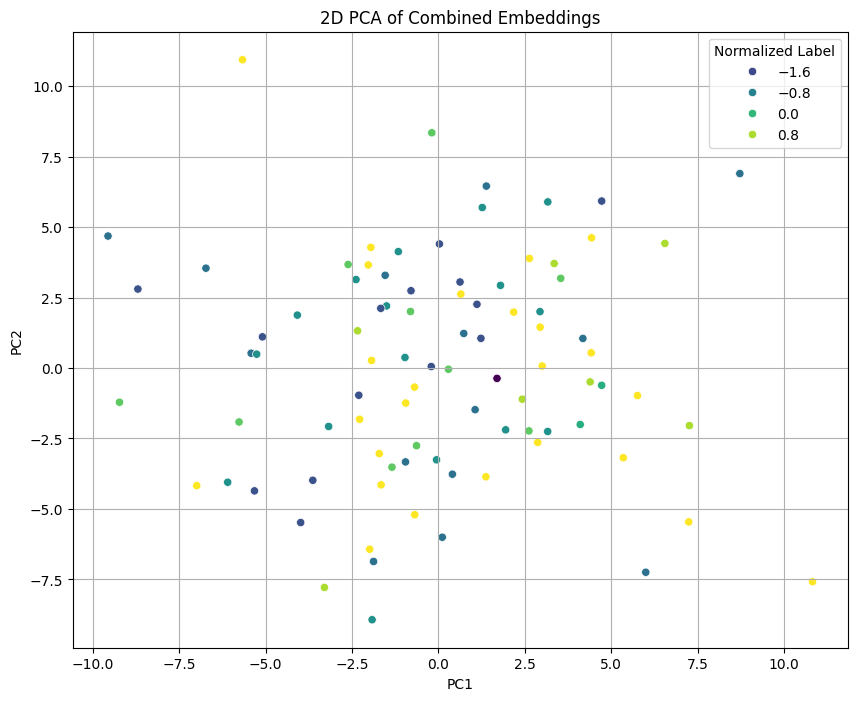

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

# Example: collect embeddings for a subset of the validation set
embeddings = []
labels_list = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        audio_emb = batch["audio_emb"].to(DEVICE)
        # Get text embeddings
        text_output = model.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = text_output.last_hidden_state[:, 0, :]
        # Normalize and combine
        text_emb = model.text_norm(text_emb)
        audio_emb = model.audio_norm(audio_emb)
        combined_emb = torch.cat([text_emb, audio_emb], dim=1)
        embeddings.append(combined_emb.cpu().numpy())
        labels_list.extend(batch["label"].cpu().numpy())

embeddings = np.vstack(embeddings)

# Apply PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels_list, palette="viridis")
plt.title('2D PCA of Combined Embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="Normalized Label", loc='best')
plt.grid(True)
plt.show()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


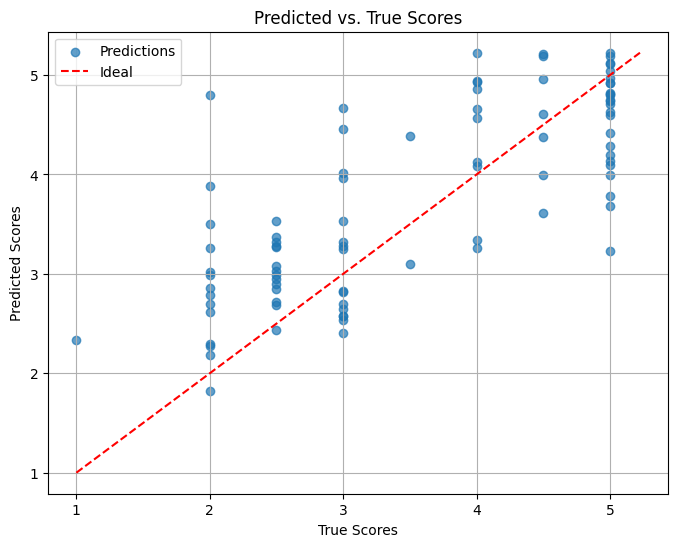

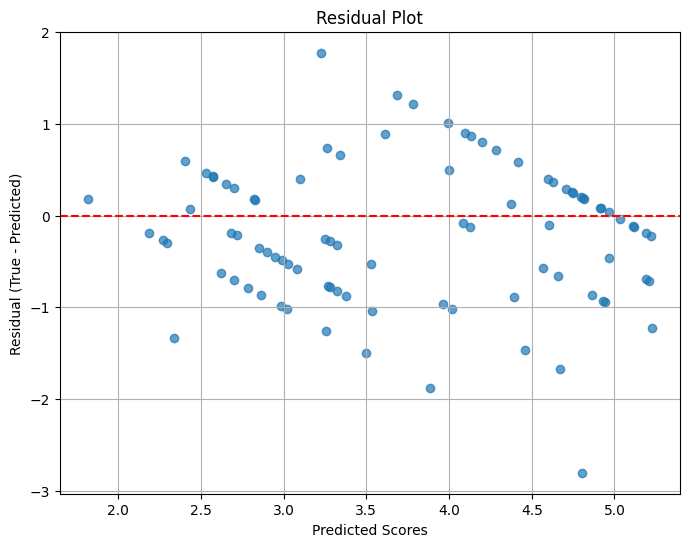

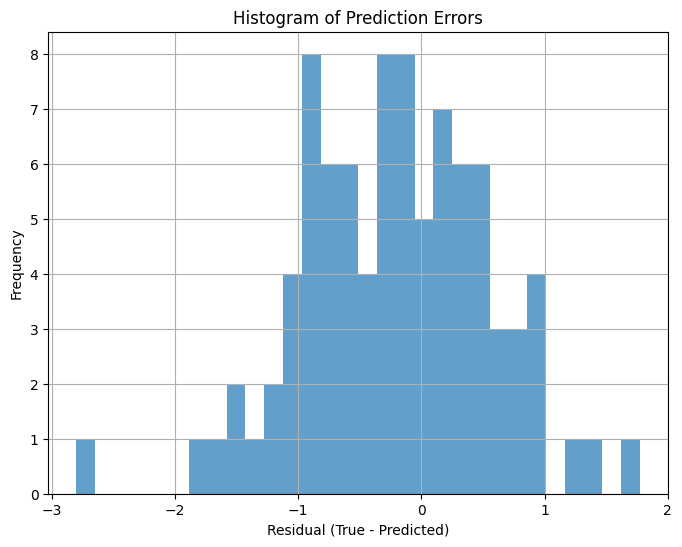

Pearson Correlation: 0.7616


In [8]:
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from transformers import AutoTokenizer, AutoModel, WhisperProcessor, WhisperModel
import torchaudio

# --- Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Configs ---
CSV_PATH = "train_with_transcripts_cleaned_filtered_N.csv"  # update if needed
AUDIO_DIR = "audios_train"
BATCH_SIZE = 8
MAX_LENGTH = 256

# --- Load Tokenizer and Models ---
text_model_name = "roberta-base"
whisper_model_name = "openai/whisper-small"

text_tokenizer = AutoTokenizer.from_pretrained(text_model_name)
text_model = AutoModel.from_pretrained(text_model_name).to(DEVICE)
# Freeze all layers except the last two
for param in text_model.parameters():
    param.requires_grad = False
for layer in text_model.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

whisper_processor = WhisperProcessor.from_pretrained(whisper_model_name)
whisper_model = WhisperModel.from_pretrained(whisper_model_name).to(DEVICE)
whisper_model.eval()
for param in whisper_model.parameters():
    param.requires_grad = False

# --- Audio Embedding Extraction Function ---
def extract_whisper_embedding(audio_path):
    try:
        waveform, sr = torchaudio.load(audio_path)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        if sr != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
            waveform = resampler(waveform)
        inputs = whisper_processor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt")
        with torch.no_grad():
            encoder_outputs = whisper_model.encoder(inputs.input_features.to(DEVICE))
            emb = encoder_outputs.last_hidden_state.mean(dim=1).squeeze()
        return emb.cpu()
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return torch.zeros(768)

# --- Dataset Definition ---
class HybridGrammarDataset(Dataset):
    def __init__(self, df, tokenizer, audio_dir, max_length=256, mean=None, std=None):
        self.df = df
        self.tokenizer = tokenizer
        self.audio_dir = audio_dir
        self.max_length = max_length
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["cleaned_text"] if pd.notna(row["cleaned_text"]) else "[EMPTY]"
        audio_path = os.path.join(self.audio_dir, row["filename"])
        text_inputs = self.tokenizer(text, return_tensors="pt", truncation=True, 
                                     max_length=self.max_length, padding="max_length")
        input_ids = text_inputs["input_ids"].squeeze(0)
        attention_mask = text_inputs["attention_mask"].squeeze(0)
        audio_emb = extract_whisper_embedding(audio_path)
        label = torch.tensor(row["label"], dtype=torch.float)
        if self.mean is not None and self.std is not None:
            label = (label - self.mean) / self.std
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "audio_emb": audio_emb,
            "label": label
        }

# --- Load Data ---
full_df = pd.read_csv(CSV_PATH)
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)
train_mean = train_df["label"].mean()
train_std = train_df["label"].std()

val_dataset = HybridGrammarDataset(val_df, text_tokenizer, AUDIO_DIR, max_length=MAX_LENGTH,
                                   mean=train_mean, std=train_std)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# --- Model Definition ---
class HybridGrammarScorer(torch.nn.Module):
    def __init__(self, text_model, hidden_size_text=768, hidden_size_audio=768, combined_hidden=256):
        super().__init__()
        self.text_model = text_model
        self.audio_norm = torch.nn.LayerNorm(hidden_size_audio)
        self.text_norm = torch.nn.LayerNorm(hidden_size_text)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_size_text + hidden_size_audio, combined_hidden),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(combined_hidden),
            torch.nn.Linear(combined_hidden, combined_hidden//2),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(combined_hidden//2),
            torch.nn.Linear(combined_hidden//2, 1)
        )

    def forward(self, input_ids, attention_mask, audio_emb):
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        # Use the [CLS] token representation
        text_emb = text_output.last_hidden_state[:, 0, :]
        text_emb = self.text_norm(text_emb)
        audio_emb = self.audio_norm(audio_emb)
        combined = torch.cat([text_emb, audio_emb], dim=1)
        return self.fc(combined)

# --- Load Saved Model ---
model = HybridGrammarScorer(text_model).to(DEVICE)
model.load_state_dict(torch.load("best_whisper_hybrid_model.pt", map_location=DEVICE))
model.eval()

# --- Run Predictions on Validation Set ---
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        audio_emb = batch["audio_emb"].to(DEVICE)
        labels = batch["label"].to(DEVICE).unsqueeze(1)

        preds = model(input_ids, attention_mask, audio_emb)
        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

# Denormalize predictions and labels using training stats
all_preds = np.array(all_preds) * train_std + train_mean
all_labels = np.array(all_labels) * train_std + train_mean

# Calculate residuals (error)
residuals = all_labels - all_preds

# --- Scatter Plot: Predicted vs. True Scores ---
plt.figure(figsize=(8, 6))
plt.scatter(all_labels, all_preds, alpha=0.7, label="Predictions")
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.title("Predicted vs. True Scores")
min_val = min(all_labels.min(), all_preds.min())
max_val = max(all_labels.max(), all_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal")
plt.legend()
plt.grid(True)
plt.show()

# --- Residual Plot: Residuals vs. Predicted Scores ---
plt.figure(figsize=(8, 6))
plt.scatter(all_preds, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Scores")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

# --- Histogram of Residuals ---
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors")
plt.grid(True)
plt.show()

# --- Optional: Print Performance Metrics ---
pearson_corr, _ = pearsonr(all_preds, all_labels)
print(f"Pearson Correlation: {pearson_corr:.4f}")
